In [1]:
import pathlib
import pandas as pd
from joblib import load

import skimage
import matplotlib.pyplot as plt

import sys
sys.path.append("../utils")
from split_utils import get_features_data
from train_utils import get_dataset

In [2]:
model_dir = pathlib.Path("../2.train_model/models/")
log_reg_model_path = pathlib.Path(f"{model_dir}/log_reg_model.joblib")
log_reg_model = load(log_reg_model_path)

# load features data from indexes and features dataframe
data_split_path = pathlib.Path("../1.split_data/indexes/data_split_indexes.tsv")
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
features_dataframe_path = pathlib.Path("../0.download_data/data/training_data.csv.gz")
features_dataframe = get_features_data(features_dataframe_path)

test_data = get_dataset(features_dataframe, data_split_indexes, "test")

/home/roshankern/anaconda3/envs/idrstream_dp/lib/python3.8/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
def get_frame_metadata(frame_details: str):
    """
    get frame metadata from features samples movie details string
    Parameters
    ----------
    frame_details : str
        string from one line of features samples file
        ex: PLLT0010_27--ex2005_05_13--sp2005_03_23--tt17--c5___P00173_01___T00082___X0397___Y0618
    Returns
    -------
    plate: str
        plate of sample
    well_num: int
        well number of sample
    frame: int
        frame of sample
    """

    plate = frame_details.split("--")[0].replace("PL", "")
    well_num = int(frame_details.split("___")[1][1:6])
    frame = int(frame_details.split("___")[2][1:6]) + 1
    x = int(frame_details.split("___")[3][1:6])
    y = int(frame_details.split("___")[4][1:6])

    return plate, well_num, frame, x, y

In [4]:
single_cell_images_path = pathlib.Path("/home/roshankern/Desktop/Classifier_full_2015_06_04_b/samples/")

def get_frame_path(g_phenotypic_class, g_plate, g_well_num, g_frame, g_x, g_y):
    for class_dir_path in single_cell_images_path.iterdir():
        for frame_path in class_dir_path.iterdir():
            phenotypic_class = class_dir_path.name
            plate, well_num, frame, x, y = get_frame_metadata(frame_path.name)

            if (
                g_phenotypic_class == phenotypic_class
                and g_plate == plate
                and g_well_num == well_num
                and g_frame == frame
                and abs(g_x-x)<10
                and abs(g_y-y)<10
            ):
                return frame_path
            
    return "none"

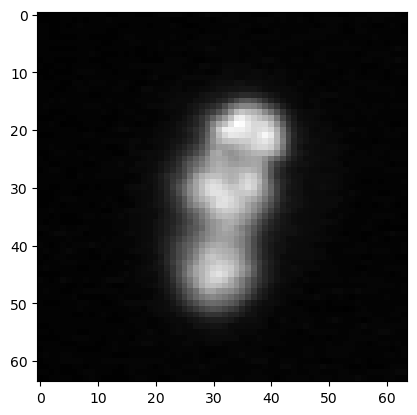

^ True label -- ADCCM; Predicted label -- ADCCM ^


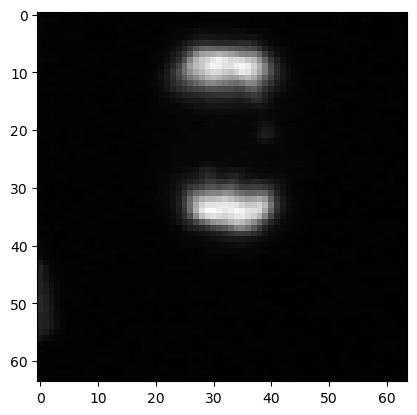

^ True label -- Anaphase; Predicted label -- Anaphase ^


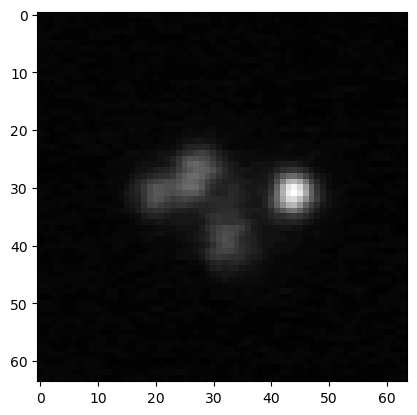

^ True label -- Apoptosis; Predicted label -- Apoptosis ^


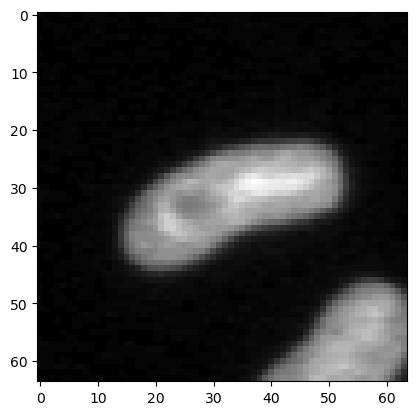

^ True label -- Elongated; Predicted label -- Elongated ^


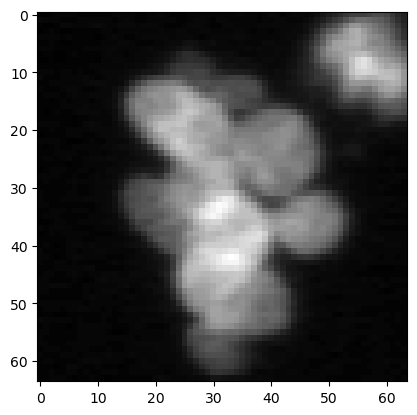

^ True label -- Grape; Predicted label -- Polylobed ^


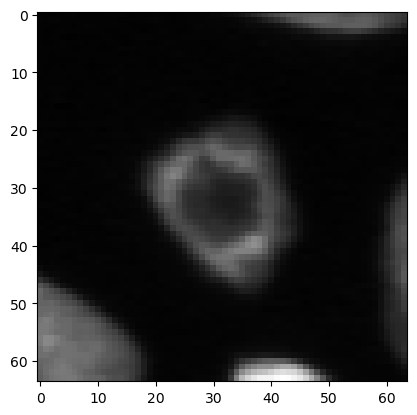

^ True label -- Hole; Predicted label -- Elongated ^


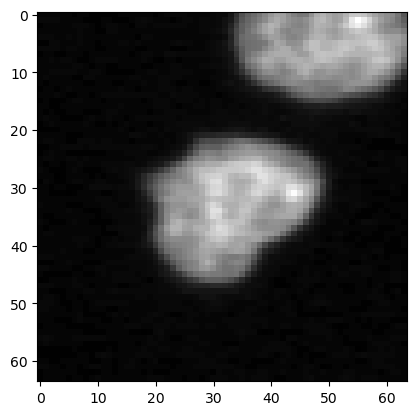

^ True label -- Interphase; Predicted label -- Binuclear ^


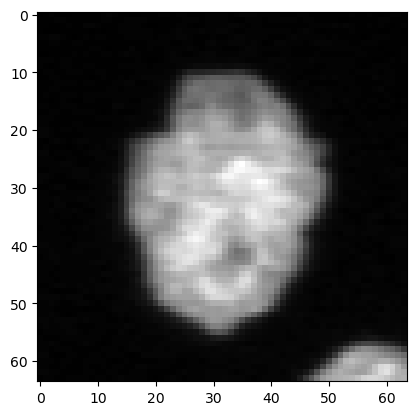

^ True label -- Large; Predicted label -- Large ^


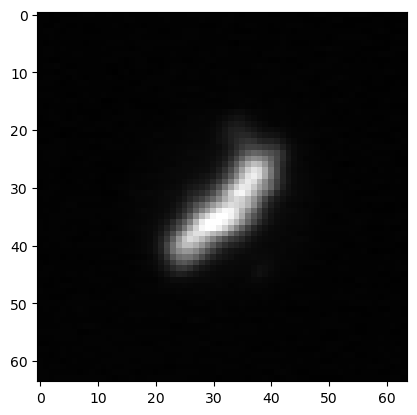

^ True label -- Metaphase; Predicted label -- Metaphase ^


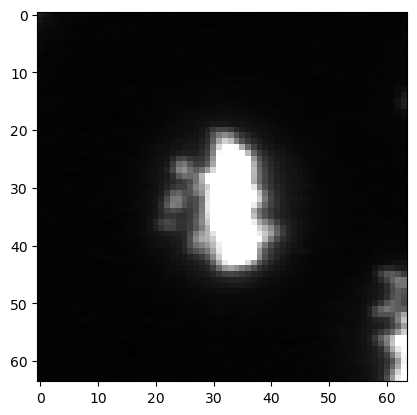

^ True label -- MetaphaseAlignment; Predicted label -- Prometaphase ^


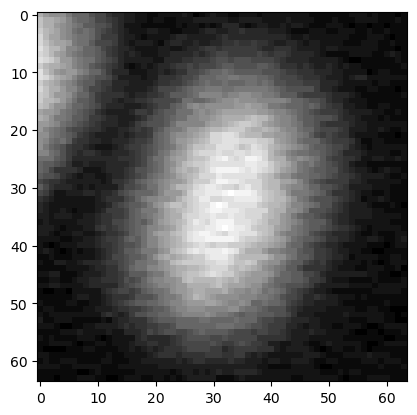

^ True label -- OutOfFocus; Predicted label -- OutOfFocus ^


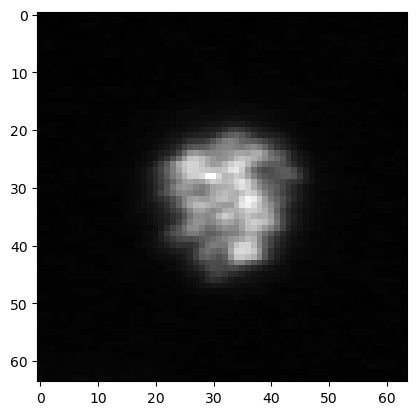

^ True label -- Prometaphase; Predicted label -- Prometaphase ^


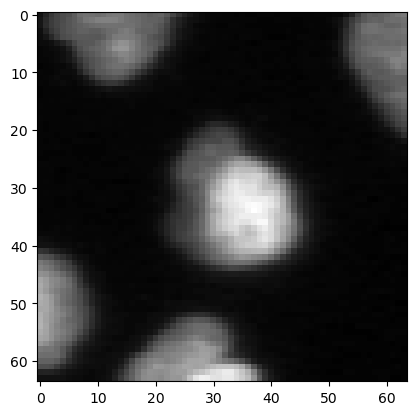

^ True label -- SmallIrregular; Predicted label -- SmallIrregular ^


In [5]:
feature_columns = [column for column in test_data.columns if "efficientnet" in column]
classes_displayed = []

for index, row in test_data.iterrows():
    phenotypic_class = row["Mitocheck_Phenotypic_Class"]
    if phenotypic_class in classes_displayed:
        continue
    
    frame_path = get_frame_path(
        phenotypic_class,
        row["Metadata_Plate"],
        row["Metadata_Well"],
        row["Metadata_Frame"],
        row["Location_Center_X"],
        row["Location_Center_Y"]
    )
    
    if(frame_path != "none"):
        image_data = skimage.io.imread(frame_path)
        plt.imshow(image_data, cmap="gray")
        plt.show()
        
        cell_features = row[feature_columns].to_numpy().reshape(1, -1)
        cell_class_prediction = log_reg_model.predict(cell_features)[0]
        print(f"^ True label -- {phenotypic_class}; Predicted label -- {cell_class_prediction} ^")
        
        classes_displayed.append(phenotypic_class)